### Generación de Data

+----+------+-------------------+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------+-----------------------+--------+---------+--------+----------------+-------------------+--------------------------+-------------------------+-------------+------------------------------+--------------+
|    |   ID | Fecha de Dosaje   |   Hemoglobina |   Valor Hemoglobina Futura 1M |   Valor Hemoglobina Futura 3M |   Valor Hemoglobina Futura 6M | Nivel de Anemia   | Fecha de Nacimiento   |   Peso |   Talla | Sexo   |   Edad (meses) |   Nivel de Hierro |   Estado de Recuperación | Fecha de Recuperación   | Provincia   | Distrito                     |   Altura (m) |
|----+------+-------------------+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------+-----------------------+--------+---------+--------+----------------+-------------------+----------

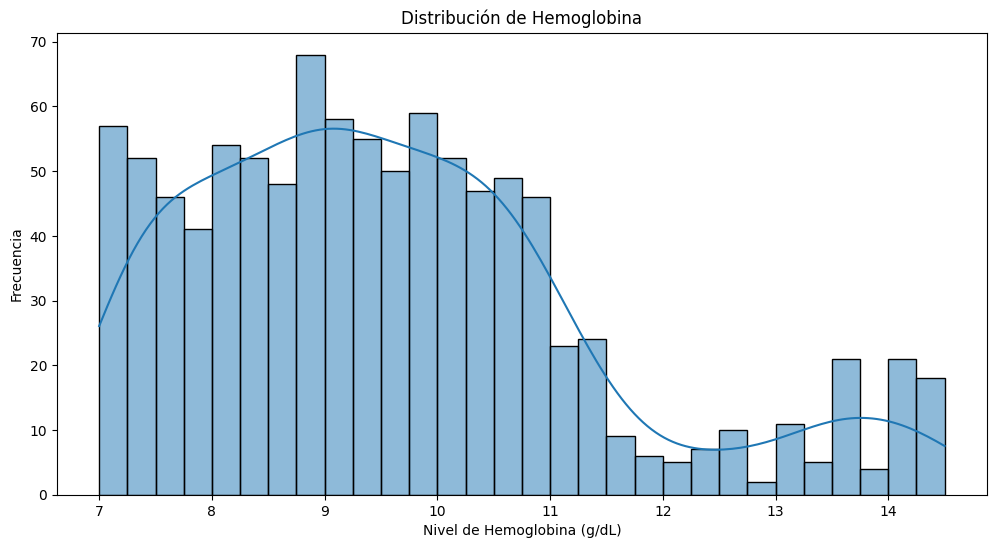

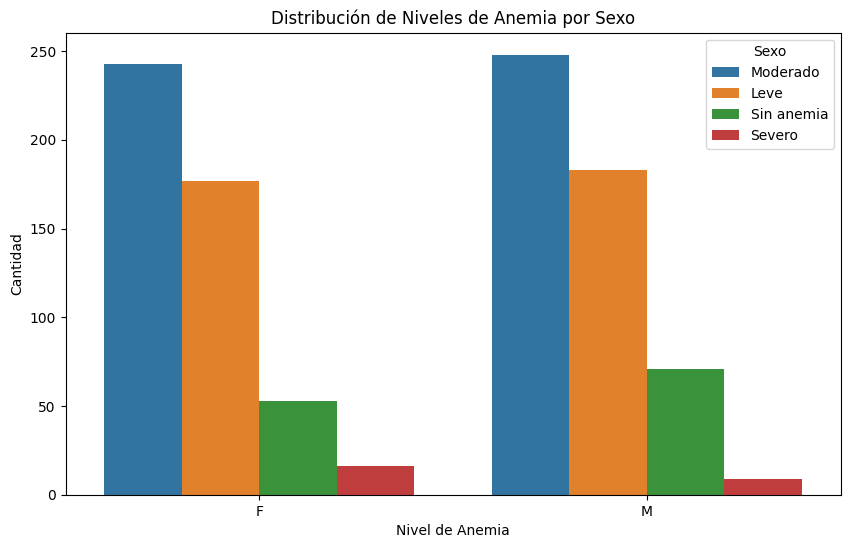

              precision    recall  f1-score   support

        Leve       1.00      1.00      1.00       360
    Moderado       1.00      1.00      1.00       491
      Severo       1.00      1.00      1.00        25
  Sin anemia       1.00      1.00      1.00       124

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



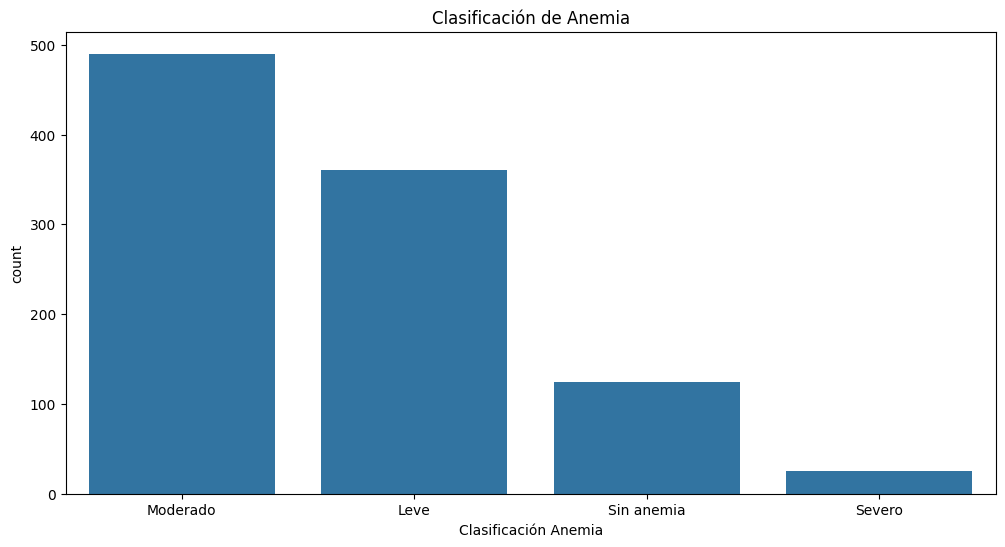

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Constantes para la clasificación de anemia
SIN_ANEMIA = "Sin anemia"
LEVE = "Leve"
MODERADO = "Moderado"
SEVERO = "Severo"

# Definir las provincias y sus respectivas alturas y distritos
provincias_distritos_alturas = {
    "Chanchamayo": (775, ["Chanchamayo", "San Luis de Shuaro", "Perené", "Pichanaqui", "San Ramón", "Vitoc"]),
    "Chupaca": (3281, ["Chupaca", "Ahuac", "Chongos Bajo", "Huáchac", "Huamancaca Chico", "San Juan de Yscos", "San Juan de Jarpa", "Tres de Diciembre", "Yanacancha"]),
    "Concepción": (3286, ["Concepción", "Aco", "Andamarca", "Chambara", "Cochas", "Comas", "Heroínas Toledo", "Manzanares", "Mariscal Castilla", "Mito", "Nueve de Julio", "Orcotuna", "San José de Quero", "Santa Rosa de Ocopa"]),
    "Huancayo": (3245, ["Huancayo", "Carhuacallanga", "Chicche", "Chilca", "Chongos Alto", "Chupuro", "Colca", "Cullhuas", "El Tambo", "Huacrapuquio", "Hualhuas", "Huancán", "Huasicancha", "Huayucachi", "Ingenio", "Pariahuanca", "Pilcomayo", "Pucará", "Quilcas", "San Agustín", "San Jerónimo de Tunán", "Saño", "Sapallanga", "Sicaya", "Viques"]),
    "Jauja": (3389, ["Jauja", "Acolla", "Apata", "Ataura", "Canchayllo", "Curicaca", "El Mantaro", "Huamalí", "Huaripampa", "Huertas", "Janjaillo", "Julcán", "Leonor Ordóñez", "Llocllapampa", "Marco", "Masma", "Masma Chicche", "Molinos", "Monobamba", "Muqui", "Muquiyauyo", "Paca", "Paccha", "Pancán", "Parco", "Pomacancha", "Ricrán", "San Lorenzo", "San Pedro de Chunan", "Sausa", "Sincos", "Tunan Marca", "Yauli", "Yauyos"]),
    "Junín": (4113, ["Junín", "Carhuamayo", "Ondores", "Ulcumayo"]),
    "Satipo": (628, ["Satipo", "Coviriali", "Llaylla", "Mazamari", "Pampa Hermosa", "Pangoa", "Río Negro", "Río Tambo"]),
    "Tarma": (3059, ["Tarma", "Acobamba", "Huaricolca", "Huasahuasi", "La Unión", "Palca", "Palcamayo", "San Pedro de Cajas", "Tapo"]),
    "Yauli": (3725, ["La Oroya", "Chacapalpa", "Huay-Huay", "Marcapomacocha", "Morococha", "Paccha", "Santa Bárbara de Carhuacayán", "Santa Rosa de Sacco", "Suitucancha"])
}

def obtener_provincia_distrito():
    provincia = np.random.choice(list(provincias_distritos_alturas.keys()), p=[0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    altura, distritos = provincias_distritos_alturas[provincia]
    distrito = np.random.choice(distritos)
    return provincia, distrito, altura

# Clasificación de anemia según la normativa NTS N°134-MINSA/2017
def clasificar_anemia(hemoglobina, edad_meses):
    if 6 <= edad_meses < 12:
        if hemoglobina >= 10.5:
            return SIN_ANEMIA
        elif 9.0 <= hemoglobina < 10.5:
            return LEVE
        elif 7.0 <= hemoglobina < 9.0:
            return MODERADO
        else:
            return SEVERO
    elif 12 <= edad_meses < 24:
        if hemoglobina >= 11.0:
            return SIN_ANEMIA
        elif 9.0 <= hemoglobina < 11.0:
            return LEVE
        elif 7.0 <= hemoglobina < 9.0:
            return MODERADO
        else:
            return SEVERO
    elif 24 <= edad_meses < 36:
        if hemoglobina >= 11.5:
            return SIN_ANEMIA
        elif 10.0 <= hemoglobina < 11.5:
            return LEVE
        elif 8.0 <= hemoglobina < 10.0:
            return MODERADO
        else:
            return SEVERO
    return "NO CLASIFICABLE"

def limitar_hemoglobina(hemoglobina, edad_meses):
    if 6 <= edad_meses < 12:
        return max(7.0, min(13.5, hemoglobina))
    elif 12 <= edad_meses < 24:
        return max(7.0, min(14.0, hemoglobina))
    elif 24 <= edad_meses < 36:
        return max(8.0, min(14.5, hemoglobina))
    return hemoglobina

def generar_datos(n_registros, fecha_inicio, fecha_fin):
    data = []
    fecha_actual = fecha_fin

    for _ in range(n_registros):
        #
        edad_meses = np.random.randint(6, 36)
        fecha_nacimiento = fecha_actual - relativedelta(months=edad_meses)

        # Calcular el rango de fechas posibles para el dosaje (de 0 a 12 meses después de la fecha de nacimiento)
        max_dosaje_delta = timedelta(days=365)  # Máximo 1 año después de la fecha de nacimiento
        fecha_dosaje = fecha_nacimiento + timedelta(days=np.random.randint(0, 365))

        # Asegurarse de que la fecha de dosaje esté dentro del rango deseado
        while fecha_dosaje < fecha_nacimiento or fecha_dosaje > fecha_nacimiento + max_dosaje_delta:
            fecha_dosaje = fecha_nacimiento + timedelta(days=np.random.randint(0, 365))

        # Ajustar la media de hemoglobina para aumentar la prevalencia de anemia
        provincia, distrito, altura_provincia = obtener_provincia_distrito()
        nivel_hierro_base = np.random.normal(11, 1)
        nivel_hierro = nivel_hierro_base * (1 + altura_provincia / 30000)

        # Factores adicionales
        factor_dieta = np.random.normal(1, 0.1)  # Factor de ajuste por dieta
        factor_altitud = 1 + altura_provincia / 20000  # Ajuste por altitud
        factor_ejercicio = np.random.normal(1, 0.05)  # Factor de ajuste por ejercicio

        # Generar valor de hemoglobina actual basado en la edad
        if 6 <= edad_meses < 12:
            hemoglobina = np.random.uniform(7.0, 13.5)
        elif 12 <= edad_meses < 24:
            hemoglobina = np.random.uniform(7.0, 14.0)
        elif 24 <= edad_meses < 36:
            hemoglobina = np.random.uniform(8.0, 14.5)
        else:
            hemoglobina = np.random.uniform(7.0, 13.5)  # Valor por defecto para edades fuera del rango

        # Ajustar hemoglobina con factores adicionales
        hemoglobina = round(
            hemoglobina * factor_altitud * factor_dieta * factor_ejercicio +
            np.random.normal(0, 0.5),
            # Agregar ruido gaussiano
            2
        )

        # Limitar el valor de hemoglobina actual a un rango razonable
        hemoglobina = limitar_hemoglobina(hemoglobina, edad_meses)

        # Aumentar la probabilidad de anemia leve, moderada o severa
        if np.random.rand() < 0.8:  # 80% de probabilidad de tener anemia
            if 6 <= edad_meses < 12:
                hemoglobina = np.random.uniform(7.0, 10.4)
            elif 12 <= edad_meses < 24:
                hemoglobina = np.random.uniform(7.0, 10.9)
            elif 24 <= edad_meses < 36:
                hemoglobina = np.random.uniform(8.0, 11.4)
            # Aumentar ligeramente la probabilidad de hemoglobina en el nivel severo
            if np.random.rand() < 0.1:  # 10% de probabilidad de tener anemia severa
                hemoglobina = np.random.uniform(7.0, 8.0)

        nivel_anemia = clasificar_anemia(hemoglobina, edad_meses)

        # Distribución probabilística para el sexo (realidad peruana)
        sexo = np.random.choice(["M", "F"], p=[0.51, 0.49])

        if edad_meses < 12:
            peso_dosaje = np.random.normal(8 + edad_meses * 0.5, 1)
            talla = np.random.normal(65 + edad_meses * 2, 3)
        elif edad_meses < 36:
            peso_dosaje = np.random.normal(10 + (edad_meses - 12) * 0.3, 1.5)
            talla = np.random.normal(80 + (edad_meses - 12) * 1, 4)
        else:
            peso_dosaje = np.random.normal(13 + (edad_meses - 36) * 0.2, 2)
            talla = np.random.normal(95 + (edad_meses - 36) * 0.5, 5)

        peso_dosaje = max(3, min(25, peso_dosaje))
        talla = max(50, min(140, talla))

        # Estado de recuperación
        estado_recuperacion = 0
        fecha_recuperacion = None

        # Factores que afectan el cambio de hemoglobina
        tratamiento_hierro = np.random.normal(1, 0.1)  # Tratamiento con hierro (peso 40%)
        nutricion = np.random.normal(1, 0.1)  # Nutrición (peso 25%)
        estado_salud = np.random.normal(1, 0.1)  # Estado de salud (infecciones) (peso 20%)
        acceso_salud = np.random.normal(1, 0.05)  # Acceso a servicios de salud (peso 10%)
        condiciones_socioeconomicas = np.random.normal(1, 0.05)  # Condiciones socioeconómicas (peso 5%)

        # Generar valor de hemoglobina futura al primer mes
        if np.random.rand() < 0.9:  # 90% de probabilidad de aumento con tratamiento
            cambio_hemoglobina_1m = np.random.uniform(0.5, 1.5)
        else:
            cambio_hemoglobina_1m = -np.random.uniform(0.1, 0.3)
        valor_hemoglobina_futura_1m = round(
            hemoglobina + cambio_hemoglobina_1m * (
                0.4 * tratamiento_hierro +
                0.25 * nutricion +
                0.2 * estado_salud +
                0.1 * acceso_salud +
                0.05 * condiciones_socioeconomicas
            ),
            2
        )
        valor_hemoglobina_futura_1m = limitar_hemoglobina(valor_hemoglobina_futura_1m, edad_meses)

        # Generar valor de hemoglobina futura a los tres meses basado en el valor del primer mes
        if np.random.rand() < 0.9:  # 90% de probabilidad de aumento con tratamiento
            cambio_hemoglobina_3m = np.random.uniform(1.5, 3.0)
        else:
            cambio_hemoglobina_3m = -np.random.uniform(0.3, 1.0)
        valor_hemoglobina_futura_3m = round(
            valor_hemoglobina_futura_1m + cambio_hemoglobina_3m * (
                0.4 * tratamiento_hierro +
                0.25 * nutricion +
                0.2 * estado_salud +
                0.1 * acceso_salud +
                0.05 * condiciones_socioeconomicas
            ),
            2
        )
        valor_hemoglobina_futura_3m = limitar_hemoglobina(valor_hemoglobina_futura_3m, edad_meses)

        # Generar valor de hemoglobina futura a los seis meses basado en el valor de los tres meses
        if np.random.rand() < 0.9:  # 90% de probabilidad de aumento con tratamiento
            cambio_hemoglobina_6m = np.random.uniform(2.0, 4.5)
        else:
            cambio_hemoglobina_6m = -np.random.uniform(1.0, 2.0)
        valor_hemoglobina_futura_6m = round(
            valor_hemoglobina_futura_3m + cambio_hemoglobina_6m * (
                0.4 * tratamiento_hierro +
                0.25 * nutricion +
                0.2 * estado_salud +
                0.1 * acceso_salud +
                0.05 * condiciones_socioeconomicas
            ),
            2
        )
        valor_hemoglobina_futura_6m = limitar_hemoglobina(valor_hemoglobina_futura_6m, edad_meses)

        # Actualizar estado de recuperación si se ha recuperado en algún momento
        if nivel_anemia == SIN_ANEMIA:
            estado_recuperacion = 1
            fecha_recuperacion = fecha_dosaje
        elif clasificar_anemia(valor_hemoglobina_futura_1m, edad_meses + 1) == SIN_ANEMIA:
            estado_recuperacion = 1
            fecha_recuperacion = fecha_dosaje + relativedelta(months=1)
        elif clasificar_anemia(valor_hemoglobina_futura_3m, edad_meses + 3) == SIN_ANEMIA:
            estado_recuperacion = 1
            fecha_recuperacion = fecha_dosaje + relativedelta(months=3)
        elif clasificar_anemia(valor_hemoglobina_futura_6m, edad_meses + 6) == SIN_ANEMIA:
            estado_recuperacion = 1
            fecha_recuperacion = fecha_dosaje + relativedelta(months=6)

        data.append([  # Se agrega el contador en el índice 0
            None,  # Placeholder para el contador
            fecha_dosaje.strftime('%d/%m/%Y'),
            round(hemoglobina, 2),
            round(valor_hemoglobina_futura_1m, 2),
            round(valor_hemoglobina_futura_3m, 2),
            round(valor_hemoglobina_futura_6m, 2),
            nivel_anemia,
            fecha_nacimiento.strftime('%d/%m/%Y'),
            round(peso_dosaje, 2),
            round(talla, 2),
            sexo,
            edad_meses,
            round(nivel_hierro, 2),
            estado_recuperacion,
            fecha_recuperacion.strftime('%d/%m/%Y') if fecha_recuperacion else None,
            provincia,
            distrito,
            altura_provincia
        ])

    return data

# Generar datos
n_registros = 1000
fecha_inicio = datetime(2020, 1, 1)
fecha_fin = datetime(2023, 12, 31)
data = generar_datos(n_registros, fecha_inicio, fecha_fin)

# Crear el dataframe de pandas
df = pd.DataFrame(data, columns=[  # Definimos las columnas
    "ID", "Fecha de Dosaje", "Hemoglobina", "Valor Hemoglobina Futura 1M", "Valor Hemoglobina Futura 3M", "Valor Hemoglobina Futura 6M", "Nivel de Anemia",
    "Fecha de Nacimiento", "Peso", "Talla", "Sexo", "Edad (meses)", "Nivel de Hierro",
    "Estado de Recuperación", "Fecha de Recuperación", "Provincia", "Distrito", "Altura (m)"
])

# Asignar ID automáticamente
df["ID"] = df.index + 1

# Imprimir primeros 10 datos del DataFrame
print(tabulate(df.head(10), headers='keys', tablefmt='psql'))

# Visualización de los datos
plt.figure(figsize=(12, 6))
sns.histplot(df['Hemoglobina'], kde=True, bins=30)
plt.title('Distribución de Hemoglobina')
plt.xlabel('Nivel de Hemoglobina (g/dL)')
plt.ylabel('Frecuencia')
plt.show()

# Guardar el DataFrame en un archivo CSV para su posterior análisis
df.to_csv('datos_anemia_BD.csv', index=False)

# Gráficos y análisis (Ejemplo)
plt.figure(figsize=(10, 6))
sns.countplot(x='Sexo', hue='Nivel de Anemia', data=df)
plt.title('Distribución de Niveles de Anemia por Sexo')
plt.xlabel('Nivel de Anemia')
plt.ylabel('Cantidad')
plt.legend(title='Sexo')
plt.show()

# Clasificación de anemia
df['Clasificación Anemia'] = df.apply(lambda row: clasificar_anemia(row['Hemoglobina'], row['Edad (meses)']), axis=1)

# Reporte de clasificación
print(classification_report(df['Nivel de Anemia'], df['Clasificación Anemia']))

# Visualización de la clasificación de anemia
plt.figure(figsize=(12, 6))
sns.countplot(x='Clasificación Anemia', data=df)
plt.title('Clasificación de Anemia')
plt.show()

### ALGORITMO DE PREDICCIÓN DE VALOR DE HEMOGLOBINA

+-------+---------------------+--------------------+--------------------+-------------------------+
| Meses |      R2 Score       |        MSE         |        MAE         | Porcentaje de Precisión |
+-------+---------------------+--------------------+--------------------+-------------------------+
|   1   | 0.9269074838957052  | 0.2311682386499996 | 0.3592174999999994 |    95.20403871829106    |
|   3   | 0.5436582414355611  | 1.3773715428499986 | 0.8002944999999994 |    89.32940666666667    |
|   6   | 0.09244920698420833 |    2.0492316281    | 0.8255729999999997 |        88.99236         |
+-------+---------------------+--------------------+--------------------+-------------------------+


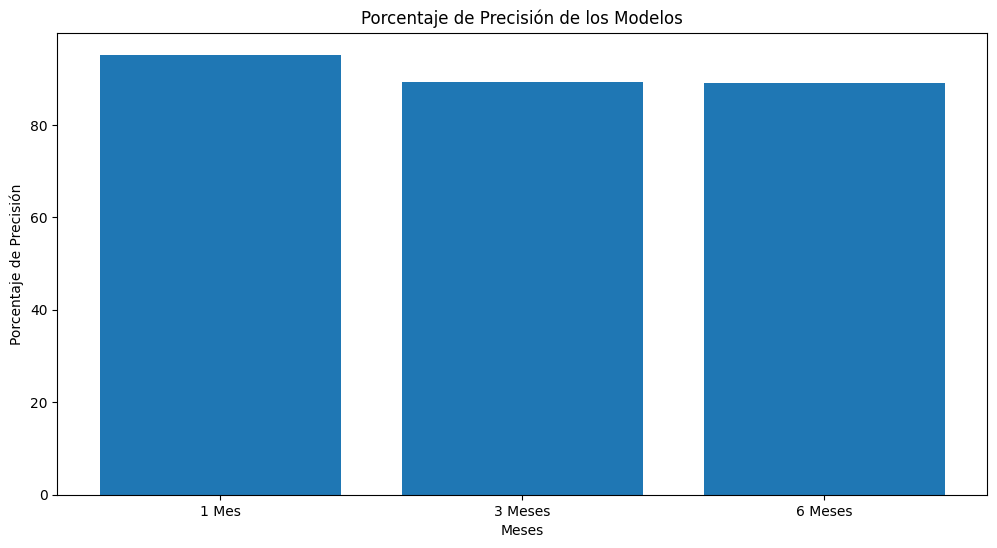

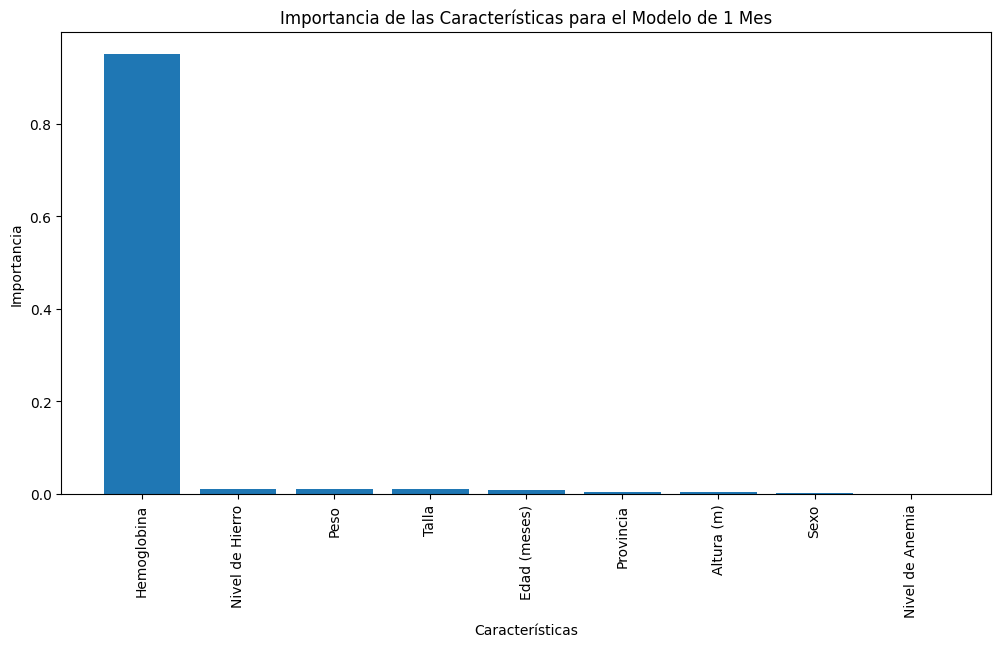

El modelo espera las siguientes características en este orden:
['Hemoglobina' 'Nivel de Anemia' 'Peso' 'Talla' 'Sexo' 'Edad (meses)'
 'Nivel de Hierro' 'Provincia' 'Altura (m)']
Predicción de Hemoglobina a 1 Mes: 11.29 g/dL


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tabulate import tabulate
import matplotlib.pyplot as plt
import joblib

# Cargar los datos
data = pd.read_csv('datos_anemia.csv')

# Convertir las fechas a un formato numérico
data['Fecha de Dosaje'] = pd.to_datetime(data['Fecha de Dosaje'], format='%d/%m/%Y')
data['Fecha de Nacimiento'] = pd.to_datetime(data['Fecha de Nacimiento'], format='%d/%m/%Y')

# Eliminar las columnas de fecha que ya no necesitamos
data = data.drop(['Fecha de Dosaje', 'Fecha de Nacimiento', 'Fecha de Recuperación'], axis=1)

# Codificar provincias y distritos
le_provincia = LabelEncoder()
le_distrito = LabelEncoder()
data['Provincia'] = le_provincia.fit_transform(data['Provincia'])
data['Distrito'] = le_distrito.fit_transform(data['Distrito'])

# Codificar variables categóricas como 'Sexo' y 'Nivel de Anemia' usando LabelEncoder
le_sexo = LabelEncoder()
data['Sexo'] = le_sexo.fit_transform(data['Sexo'])
le_anemia = LabelEncoder()
data['Nivel de Anemia'] = le_anemia.fit_transform(data['Nivel de Anemia'])

# Separar características (X) y los valores a predecir (y)
X = data.drop(['Valor Hemoglobina Futura 1M', 'Valor Hemoglobina Futura 3M', 'Valor Hemoglobina Futura 6M'], axis=1)
X = X.drop([col for col in X.columns if 'Distrito' in col], axis=1)

#borrar columna ID
X = X.drop(['ID'], axis=1)

# Borrar columna de estado de recuperación
X = X.drop(['Estado de Recuperación'], axis=1)

# Seleccionar la columna de valores futuros de hemoglobina para 1 mes, 3 meses y 6 meses
y_1m = data['Valor Hemoglobina Futura 1M']
y_3m = data['Valor Hemoglobina Futura 3M']
y_6m = data['Valor Hemoglobina Futura 6M']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train_1m, y_test_1m = train_test_split(X, y_1m, test_size=0.2, random_state=42)
_, _, y_train_3m, y_test_3m = train_test_split(X, y_3m, test_size=0.2, random_state=42)
_, _, y_train_6m, y_test_6m = train_test_split(X, y_6m, test_size=0.2, random_state=42)

# Entrenar los modelos
model_1m = RandomForestRegressor(n_estimators=100, random_state=42)
model_1m.fit(X_train, y_train_1m)

model_3m = RandomForestRegressor(n_estimators=100, random_state=42)
model_3m.fit(X_train, y_train_3m)

model_6m = RandomForestRegressor(n_estimators=100, random_state=42)
model_6m.fit(X_train, y_train_6m)

# Predecir y calcular métricas para los modelos de 1, 3 y 6 meses
y_pred_1m = model_1m.predict(X_test)
y_pred_3m = model_3m.predict(X_test)
y_pred_6m = model_6m.predict(X_test)

mse_1m = mean_squared_error(y_test_1m, y_pred_1m)
r2_1m = r2_score(y_test_1m, y_pred_1m)
mae_1m = mean_absolute_error(y_test_1m, y_pred_1m)

mse_3m = mean_squared_error(y_test_3m, y_pred_3m)
r2_3m = r2_score(y_test_3m, y_pred_3m)
mae_3m = mean_absolute_error(y_test_3m, y_pred_3m)

mse_6m = mean_squared_error(y_test_6m, y_pred_6m)
r2_6m = r2_score(y_test_6m, y_pred_6m)
mae_6m = mean_absolute_error(y_test_6m, y_pred_6m)

# Calcular el porcentaje de precisión de los modelos
rango_hemoglobina_m1 = y_test_1m.max() - y_test_1m.min()
porcentaje_precision_m1 = 100 * (1 - mae_1m / rango_hemoglobina_m1)

rango_hemoglobina_m3 = y_test_3m.max() - y_test_3m.min()
porcentaje_precision_m3 = 100 * (1 - mae_3m / rango_hemoglobina_m3)

rango_hemoglobina_m6 = y_test_6m.max() - y_test_6m.min()
porcentaje_precision_m6 = 100 * (1 - mae_6m / rango_hemoglobina_m6)

# Imprimir resultados en una tabla
print(tabulate({
    'Meses': ['1', '3', '6'],
    'R2 Score': [r2_1m, r2_3m, r2_6m],
    'MSE': [mse_1m, mse_3m, mse_6m],
    'MAE': [mae_1m, mae_3m, mae_6m],
    'Porcentaje de Precisión': [porcentaje_precision_m1, porcentaje_precision_m3, porcentaje_precision_m6]
}, headers='keys', tablefmt='pretty'))

#Hacer un gráfico con los porcentajes de precisión
plt.figure(figsize=(12, 6))
plt.bar(['1 Mes', '3 Meses', '6 Meses'], [porcentaje_precision_m1, porcentaje_precision_m3, porcentaje_precision_m6])
plt.title('Porcentaje de Precisión de los Modelos')
plt.xlabel('Meses')
plt.ylabel('Porcentaje de Precisión')
plt.show()

# Visualizar la importancia de las características del modelo de 1 mes
feature_importances_1m = model_1m.feature_importances_
feature_names = X.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_1m
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.title('Importancia de las Características para el Modelo de 1 Mes')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.show()

# Guardar los modelos en archivos para su uso posterior
joblib.dump(model_1m, 'model_1m.pkl')
joblib.dump(model_3m, 'model_3m.pkl')
joblib.dump(model_6m, 'model_6m.pkl')

# Cargar los modelos
# Cargar el modelo
model_1m = joblib.load('model_1m.pkl')

# Obtener el orden de las características
feature_order = model_1m.feature_names_in_
print("El modelo espera las siguientes características en este orden:")
print(feature_order)


# Crear un nuevo registro de prueba
nuevo_registro = {
    'Hemoglobina': 10.5,
    'Nivel de Anemia': 'Moderado',
    'Peso': 10.5,
    'Talla': 75,
    'Sexo': 'M',
    'Edad (meses)': 12,
    'Nivel de Hierro': 11.5,
    'Provincia': 'Huancayo',
    'Altura (m)': 3245
}

# Codificar las variables categóricas
nuevo_registro['Sexo'] = le_sexo.transform([nuevo_registro['Sexo']])[0]
nuevo_registro['Nivel de Anemia'] = le_anemia.transform([nuevo_registro['Nivel de Anemia']])[0]
nuevo_registro['Provincia'] = le_provincia.transform([nuevo_registro['Provincia']])[0]

# Crear un DataFrame a partir del nuevo registro
nuevo_registro_df = pd.DataFrame([nuevo_registro])

# Asegurarse de que las columnas estén en el orden correcto
expected_columns = ['Hemoglobina', 'Nivel de Anemia', 'Peso', 'Talla', 'Sexo', 'Edad (meses)', 'Nivel de Hierro', 'Provincia', 'Altura (m)']
nuevo_registro_df = nuevo_registro_df[expected_columns]

# Realizar la predicción para 1 mes
prediccion_1m = model_1m.predict(nuevo_registro_df)
print(f'Predicción de Hemoglobina a 1 Mes: {prediccion_1m[0]:.2f} g/dL')



In [61]:
import pandas as pd
import joblib

# Cargar el modelo
model_1m = joblib.load('model_1m.pkl')

# Crear los registros de prueba
registros = [
    {
        "Hemoglobina": 10.5,
        "Nivel de Anemia": 'Moderado',
        "Peso": 10.51,
        "Talla": 99.4,
        "Sexo": 'M',
        "Edad (meses)": 16,
        "Nivel de Hierro": 11.9,
        "Provincia": 'Huancayo',
        "Altura (m)": 3286
    },
    {
        "Hemoglobina": 11.0,
        "Nivel de Anemia": 'Leve',
        "Peso": 12.3,
        "Talla": 105.0,
        "Sexo": 'F',
        "Edad (meses)": 24,
        "Nivel de Hierro": 15.0,
        "Provincia": 'Chupaca',
        "Altura (m)": 3300
    },
    {
        "Hemoglobina": 9.5,
        "Nivel de Anemia": 'Severo',
        "Peso": 8.5,
        "Talla": 90.0,
        "Sexo": 'M',
        "Edad (meses)": 12,
        "Nivel de Hierro": 10.5,
        "Provincia": 'Junín',
        "Altura (m)": 3100
    }
]

# Convertir los registros a un DataFrame
df_registros = pd.DataFrame(registros)

# Codificar las variables categóricas
df_registros['Sexo'] = le_sexo.transform(df_registros['Sexo'])
df_registros['Nivel de Anemia'] = le_anemia.transform(df_registros['Nivel de Anemia'])
df_registros['Provincia'] = le_provincia.transform(df_registros['Provincia'])

# Asegurarse de que las columnas estén en el orden correcto
expected_columns = ['Hemoglobina', 'Nivel de Anemia', 'Peso', 'Talla', 'Sexo', 'Edad (meses)', 'Nivel de Hierro', 'Provincia', 'Altura (m)']
df_registros = df_registros[expected_columns]

# Realizar la predicción para cada registro
predicciones = model_1m.predict(df_registros)
for i, prediccion in enumerate(predicciones):
    print(f'Predicción de Hemoglobina a 1 Mes para el registro {i+1}: {prediccion:.2f} g/dL')

Predicción de Hemoglobina a 1 Mes para el registro 1: 11.57 g/dL
Predicción de Hemoglobina a 1 Mes para el registro 2: 11.74 g/dL
Predicción de Hemoglobina a 1 Mes para el registro 3: 10.43 g/dL


### Prueba del ML con datos de la BD

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('anemia_data_BD.csv', delimiter=';')

# Codificar variables categóricas
le_provincia = LabelEncoder()
le_distrito = LabelEncoder()
le_sexo = LabelEncoder()
le_anemia = LabelEncoder()

data['Provincia'] = le_provincia.fit_transform(data['Provincia'])
data['Distrito'] = le_distrito.fit_transform(data['Distrito'])
data['Sexo'] = le_sexo.fit_transform(data['Sexo'])
data['Nivel de Anemia'] = le_anemia.fit_transform(data['Nivel de Anemia'])

# Seleccionar características y etiquetas
features = ['Hemoglobina', 'Nivel de Anemia', 'Peso', 'Talla', 'Sexo', 'Edad (meses)', 'Nivel de Hierro', 'Provincia', 'Distrito']
target_1m = 'Valor Hemoglobina Futura 1M'
target_3m = 'Valor Hemoglobina Futura 3M'
target_6m = 'Valor Hemoglobina Futura 6M'

# Eliminar filas con valores nulos en las etiquetas
data = data.dropna(subset=[target_1m, target_3m, target_6m])

X = data[features]
y_1m = data[target_1m]
y_3m = data[target_3m]
y_6m = data[target_6m]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_1m, y_test_1m = train_test_split(X_scaled, y_1m, test_size=0.2, random_state=42)
_, _, y_train_3m, y_test_3m = train_test_split(X_scaled, y_3m, test_size=0.2, random_state=42)
_, _, y_train_6m, y_test_6m = train_test_split(X_scaled, y_6m, test_size=0.2, random_state=42)

# Definir el modelo y los hiperparámetros para Randomized Search
model = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# Realizar Randomized Search para encontrar los mejores hiperparámetros
random_search_1m = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_3m = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_6m = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

random_search_1m.fit(X_train, y_train_1m)
random_search_3m.fit(X_train, y_train_3m)
random_search_6m.fit(X_train, y_train_6m)

# Obtener los mejores modelos
best_model_1m = random_search_1m.best_estimator()
best_model_3m = random_search_3m.best_estimator()
best_model_6m = random_search_6m.best_estimator()

# Realizar predicciones
y_pred_1m = best_model_1m.predict(X_test)
y_pred_3m = best_model_3m.predict(X_test)
y_pred_6m = best_model_6m.predict(X_test)

# Evaluar los modelos
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

mse_1m, r2_1m = evaluate_model(y_test_1m, y_pred_1m)
mse_3m, r2_3m = evaluate_model(y_test_3m, y_pred_3m)
mse_6m, r2_6m = evaluate_model(y_test_6m, y_pred_6m)

print(f"Evaluación del modelo para 1 mes: MSE = {mse_1m}, R² = {r2_1m}")
print(f"Evaluación del modelo para 3 meses: MSE = {mse_3m}, R² = {r2_3m}")
print(f"Evaluación del modelo para 6 meses: MSE = {mse_6m}, R² = {r2_6m}")

# Porcentaje de precisión
rango_hemoglobina_m1 = y_test_1m.max() - y_test_1m.min()
porcentaje_precision_m1 = 100 * (1 - mse_1m / rango_hemoglobina_m1)

rango_hemoglobina_m3 = y_test_3m.max() - y_test_3m.min()
porcentaje_precision_m3 = 100 * (1 - mse_3m / rango_hemoglobina_m3)

rango_hemoglobina_m6 = y_test_6m.max() - y_test_6m.min()
porcentaje_precision_m6 = 100 * (1 - mse_6m / rango_hemoglobina_m6)

print(f"Porcentaje de precisión para 1 mes: {porcentaje_precision_m1:.2f}%")
print(f"Porcentaje de precisión para 3 meses: {porcentaje_precision_m3:.2f}%")
print(f"Porcentaje de precisión para 6 meses: {porcentaje_precision_m6:.2f}%")

# Gráfico de porcentaje de precisión
plt.figure(figsize=(12, 6))
plt.bar(['1 Mes', '3 Meses', '6 Meses'], [porcentaje_precision_m1, porcentaje_precision_m3, porcentaje_precision_m6])
plt.title('Porcentaje de Precisión de los Modelos')
plt.xlabel('Meses')
plt.ylabel('Porcentaje de Precisión')
plt.show()




Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

### ALGORITMO DE PREDICCIÓN DE FECHA DE RECUPERACIÓN

In [3]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Algoritmo

C:\Users\jacia\AppData\Local\Temp\ipykernel_33976\627868370.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('datos_anemia.csv', parse_dates=['Fecha de Dosaje', 'Fecha de Nacimiento', 'Fecha de Recuperación'])
C:\Users\jacia\AppData\Local\Temp\ipykernel_33976\627868370.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('datos_anemia.csv', parse_dates=['Fecha de Dosaje', 'Fecha de Nacimiento', 'Fecha de Recuperación'])
C:\Users\jacia\AppData\Local\Temp\ipykernel_33976\627868370.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('datos_anemia.csv', parse_dates=['Fecha de Dosaje',

Resultados XGBoost:
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Porcentaje de precisión: 96.54%
Error cuadrático medio: 121.49

Resultados Random Forest:
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Porcentaje de precisión: 96.90%
Error cuadrático medio: 108.86



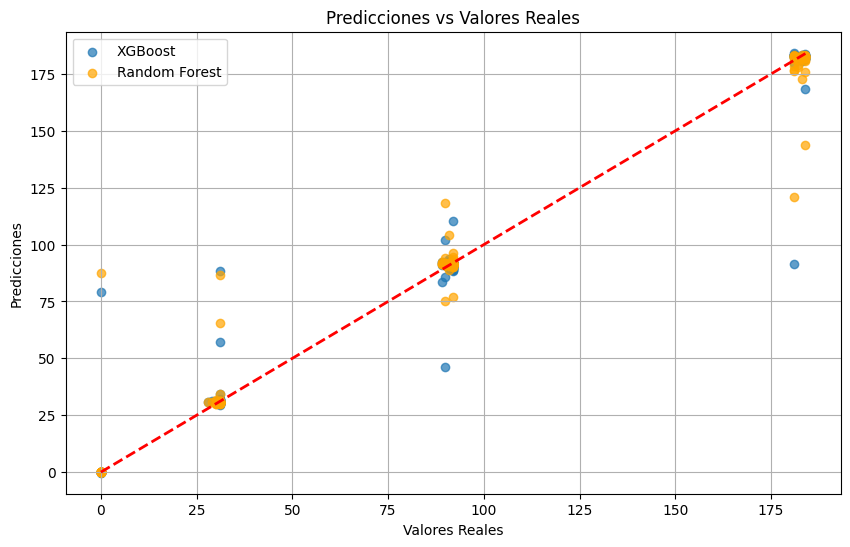

Predicción de días hasta recuperación con XGBoost: 92.03 días
Valor real: 92.0 días
Predicción de días hasta recuperación con Random Forest: 91.58 días
Predicción de días hasta recuperación con XGBoost: 30.55 días
Predicción de días hasta recuperación con Random Forest: 30.14 días


['codificadores.pkl']

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib 

# Cargar el dataset
data = pd.read_csv('datos_anemia.csv', parse_dates=['Fecha de Dosaje', 'Fecha de Nacimiento', 'Fecha de Recuperación'])

# Preprocesamiento
data['Días hasta Recuperación'] = (data['Fecha de Recuperación'] - data['Fecha de Dosaje']).dt.days
data = data.drop(columns=['ID', 'Fecha de Recuperación', 'Fecha de Nacimiento', 'Fecha de Dosaje'])

# Codificación de variables categóricas
label_encoders = {}
for column in ['Nivel de Anemia', 'Sexo', 'Provincia', 'Distrito']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Eliminar filas con valores NaN
data.dropna(inplace=True)

# Definir características (X) y objetivo (y)
X = data.drop(columns=['Días hasta Recuperación'])
y = data['Días hasta Recuperación']

# Escalar solo las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Crear el modelo Random Forest
model_rf = RandomForestRegressor(random_state=42)

# Configuración de los parámetros para la búsqueda en cuadrícula
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Búsqueda de hiperparámetros para XGBoost
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Búsqueda de hiperparámetros para Random Forest
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Mejor modelo XGBoost
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

# Mejor modelo Random Forest
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

# Calcular el error cuadrático medio y el coeficiente de determinación R^2 para XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Calcular el error cuadrático medio y el coeficiente de determinación R^2 para Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Imprimir resultados
print("Resultados XGBoost:")
print(f"Mejores hiperparámetros: {grid_search_xgb.best_params_}")
print(f"Porcentaje de precisión: {r2_xgb * 100:.2f}%")
print(f"Error cuadrático medio: {mse_xgb:.2f}\n")

print("Resultados Random Forest:")
print(f"Mejores hiperparámetros: {grid_search_rf.best_params_}")
print(f"Porcentaje de precisión: {r2_rf * 100:.2f}%")
print(f"Error cuadrático medio: {mse_rf:.2f}\n")

# Gráfico de predicciones vs valores reales para XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label='XGBoost')
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest', color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.legend()
plt.show()

# Seleccionar un registro para la prueba
sample_index = 21  # Cambia este índice para probar diferentes registros
sample_data = X_test[sample_index].reshape(1, -1)

# Realizar la predicción
predicted_days_xgb = best_model_xgb.predict(sample_data)
predicted_days_rf = best_model_rf.predict(sample_data)

# Mostrar el resultado
print(f"Predicción de días hasta recuperación con XGBoost: {predicted_days_xgb[0]:.2f} días")
print(f"Valor real: {y_test.iloc[sample_index]} días")
print(f"Predicción de días hasta recuperación con Random Forest: {predicted_days_rf[0]:.2f} días")

# Crear un nuevo registro para la prueba
nuevo_registro = {
    'Hemoglobina': 12.5,
    'Valor Hemoglobina Futura 1M': 13.0,
    'Valor Hemoglobina Futura 3M': 14.0,
    'Valor Hemoglobina Futura 6M': 15.0,
    'Nivel de Anemia': 'Leve',  # Categórico (String)
    'Peso': 60.0,
    'Talla': 165.0,
    'Sexo': 'M',  # Categórico (String)
    'Edad (meses)': 24,
    'Nivel de Hierro': 50.0,
    'Estado de Recuperación': 1,
    'Provincia': 'Junín',
    'Distrito': 'Ondores',
    'Altura (m)': 1.65
}

# Convertir el nuevo registro a un DataFrame
nuevo_registro_df = pd.DataFrame([nuevo_registro])

# Codificar las variables categóricas del nuevo registro
for column in ['Nivel de Anemia', 'Sexo', 'Provincia', 'Distrito']:
    nuevo_registro_df[column] = label_encoders[column].transform(nuevo_registro_df[column].astype(str))

# Escalar las características del nuevo registro
nuevo_registro_scaled = scaler.transform(nuevo_registro_df)

# Realizar la predicción con ambos modelos
prediccion_xgb_nuevo = best_model_xgb.predict(nuevo_registro_scaled)
prediccion_rf_nuevo = best_model_rf.predict(nuevo_registro_scaled)

# Mostrar el resultado
print(f"Predicción de días hasta recuperación con XGBoost: {prediccion_xgb_nuevo[0]:.2f} días")
print(f"Predicción de días hasta recuperación con Random Forest: {prediccion_rf_nuevo[0]:.2f} días")

# Guardar los modelos
joblib.dump(best_model_xgb, 'modelo_xgboost.pkl')
joblib.dump(best_model_rf, 'modelo_random_forest.pkl')
joblib.dump(scaler, 'escalador.pkl')
joblib.dump(label_encoders, 'codificadores.pkl')



##### Código para predecir con un nuevo Registro

In [77]:
import pandas as pd
import joblib

# Cargar los modelos y el escalador
modelo_xgboost = joblib.load('modelo_xgboost.pkl')
modelo_random_forest = joblib.load('modelo_random_forest.pkl')
escalador = joblib.load('escalador.pkl')
codificadores = joblib.load('codificadores.pkl')

# Cargar el dataset original
dataset = pd.read_csv('datos_anemia.csv')  # Asegúrate de cambiar esta ruta a la correcta

# Seleccionar las columnas relevantes para la predicción
columnas_relevantes = [
    'Hemoglobina', 'Valor Hemoglobina Futura 1M', 'Valor Hemoglobina Futura 3M',
    'Valor Hemoglobina Futura 6M', 'Nivel de Anemia', 'Peso', 'Talla', 'Sexo',
    'Edad (meses)', 'Nivel de Hierro', 'Estado de Recuperación', 'Provincia',
    'Distrito', 'Altura (m)'
]

# Filtrar el dataset para incluir solo las columnas relevantes
dataset = dataset[columnas_relevantes]

# Función para hacer predicción y comparación
def probar_registro(nuevo_registro=None, index_registro=None):
    # Si se proporciona un nuevo registro, usarlo
    if nuevo_registro is not None:
        nuevo_registro_df = pd.DataFrame([nuevo_registro])
    # Si se proporciona un índice, usar el registro del dataset
    elif index_registro is not None:
        nuevo_registro_df = dataset.iloc[[index_registro]].copy()
    else:
        raise ValueError("Debes proporcionar un nuevo registro o un índice de registro del dataset.")

    # Codificar las variables categóricas
    for column in ['Nivel de Anemia', 'Sexo', 'Provincia', 'Distrito']:
        nuevo_registro_df[column] = codificadores[column].transform(nuevo_registro_df[column].astype(str))

    # Escalar las características del nuevo registro
    nuevo_registro_scaled = escalador.transform(nuevo_registro_df)

    # Realizar la predicción con ambos modelos
    prediccion_xgb_nuevo = modelo_xgboost.predict(nuevo_registro_scaled)
    prediccion_rf_nuevo = modelo_random_forest.predict(nuevo_registro_scaled)

    # Mostrar el resultado
    print(f"Predicción de días hasta recuperación con XGBoost: {prediccion_xgb_nuevo[0]:.2f} días")
    print(f"Predicción de días hasta recuperación con Random Forest: {prediccion_rf_nuevo[0]:.2f} días")


# Crear un nuevo registro para la prueba (opcional)
nuevo_registro = {
    'Hemoglobina': 12.5,                      # Decimal (Float)
    'Valor Hemoglobina Futura 1M': 13.0,      # Decimal (Float)
    'Valor Hemoglobina Futura 3M': 14.0,      # Decimal (Float)
    'Valor Hemoglobina Futura 6M': 15.0,      # Decimal (Float)
    'Nivel de Anemia': 'Leve',                 # Categórico (String)
    'Peso': 60.0,                              # Decimal (Float)
    'Talla': 165.0,                            # Talla en centímetros (Decimal/Float)
    'Sexo': 'M',                               # Categórico (String)
    'Edad (meses)': 24,                        # Entero (Integer)
    'Nivel de Hierro': 50.0,                   # Decimal (Float)
    'Estado de Recuperación': 1,               # Entero (Integer)
    'Provincia': 'Junín',                       # String
    'Distrito': 'Ondores',                     # String
    'Altura (m)': 1.65                         # Altura en metros (Double)
}

# Ejemplo de probar con un nuevo registro
print("Probando con un nuevo registro:")
probar_registro(nuevo_registro=nuevo_registro)

# Ejemplo de probar con un registro del dataset
print("\nProbando con un registro del dataset:")
probar_registro(index_registro=0)  # Cambia el índice según el registro que quieras probar

Probando con un nuevo registro:
Predicción de días hasta recuperación con XGBoost: 30.55 días
Predicción de días hasta recuperación con Random Forest: 30.14 días

Probando con un registro del dataset:
Predicción de días hasta recuperación con XGBoost: 91.83 días
Predicción de días hasta recuperación con Random Forest: 91.47 días
